In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



from sklearn.multiclass import  OneVsRestClassifier

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train = pd.read_csv("DataSet/application_train.csv")
test = pd.read_csv("DataSet/application_test.csv")
test = reduce_mem(test)
train = reduce_mem(train)
bureau_balance = pd.read_csv("DataSet/bureau_balance.csv")
credit_card_balance = pd.read_csv("DataSet/credit_card_balance.csv")
bureau = pd.read_csv("DataSet/bureau.csv")
bureau_balance = reduce_mem(bureau_balance)
credit_card_balance = reduce_mem(credit_card_balance)
bureau = reduce_mem(bureau)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [4]:
train.shape, test.shape, 

((307511, 122), (48744, 121))

In [6]:
# Extracting the id column as a dataframe
train_id = train[["SK_ID_CURR"]]
test_id = test[["SK_ID_CURR"]]


In [28]:
#Checking if the bureau contains all of the train and test observations.
print("The total number of observations in the bureau_train ({}) and bureau_test ({}) matches with that for the train ({}) and the test ({}).".format(bureau_train .groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             bureau_test.groupby("SK_ID_CURR").sum().shape[0],
                                                                                                                                             train.shape[0], test.shape[0]))

the toral number of observations in the bureau_train (307511) and bureau_test (48744) matches with that for the train (307511) and the test (48744)


In [7]:
# Extracting only relevant observations from the bureau
bureau_train = pd.merge(train_id, bureau,how ="left", on ="SK_ID_CURR")
bureau_test  = pd.merge(test_id, bureau, how="left", on = "SK_ID_CURR")

In [21]:
# Extracting all object columns from bureau
bureau_object_cols = bureau_train.select_dtypes("object").columns.tolist()
bureau_object_cols

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [20]:
# Exploring the composition of all object columns
for col in bureau_object_cols:
    print(bureau_train[col].value_counts())

Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
currency 1    1464094
currency 2       1072
currency 3        150
currency 4          9
Name: CREDIT_CURRENCY, dtype: int64
Consumer credit                                 1069610
Credit card                                      343853
Car loan                                          23757
Mortgage                                          15607
Microloan                                          9005
Loan for business development                      1721
Another type of loan                                854
Unknown type of loan                                472
Loan for working capital replenishment              377
Cash loan (non-earmarked)                            23
Real estate loan                                     23
Loan for the purchase of equipment                   17
Loan for purchase of shares (margin lending)          4
Interbank credit                      

In [37]:
# Exploring the column the credit_active column and its relationship with the target column
bureau_credit_active = bureau_train.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].count().reset_index()
#Extracting the target column as a dataframe
target = train[["SK_ID_CURR","TARGET"]]
# Adding the target colun to the bureau_credit_active
bureau_credit_active = pd.merge(bureau_credit_active,target, how ="left" , on = "SK_ID_CURR")
# Visualizing the corrlation between the number of accounts active under credit_active and target feature.
print(bureau_credit_active.head(10))
pri(bureau_credit_active.tail(10))

(   SK_ID_CURR  CREDIT_ACTIVE  TARGET
 0      100002              8       1
 1      100003              4       0
 2      100004              2       0
 3      100006              0       0
 4      100007              1       0
 5      100008              3       0
 6      100009             18       0
 7      100010              2       0
 8      100011              4       0
 9      100012              0       0,
         SK_ID_CURR  CREDIT_ACTIVE  TARGET
 307501      456245              0       0
 307502      456246              3       0
 307503      456247             11       0
 307504      456248              0       0
 307505      456249             13       0
 307506      456251              0       0
 307507      456252              0       0
 307508      456253              4       0
 307509      456254              1       1
 307510      456255             11       0)

In [35]:
bureau_credit_active.groupby("CREDIT_ACTIVE")["TARGET"].agg(["min", "max", "mean","count", "sum"])

,min,max,mean,count,sum
CREDIT_ACTIVE,,,,,
0,0,1,0.101249,44020,4457.0
1,0,1,0.085884,36072,3098.0
2,0,1,0.078125,35635,2784.0
3,0,1,0.076082,32925,2505.0
4,0,1,0.071273,28973,2065.0
5,0,1,0.074445,24985,1860.0
6,0,1,0.072069,20952,1510.0
7,0,1,0.072715,17273,1256.0
8,0,1,0.074533,14356,1070.0


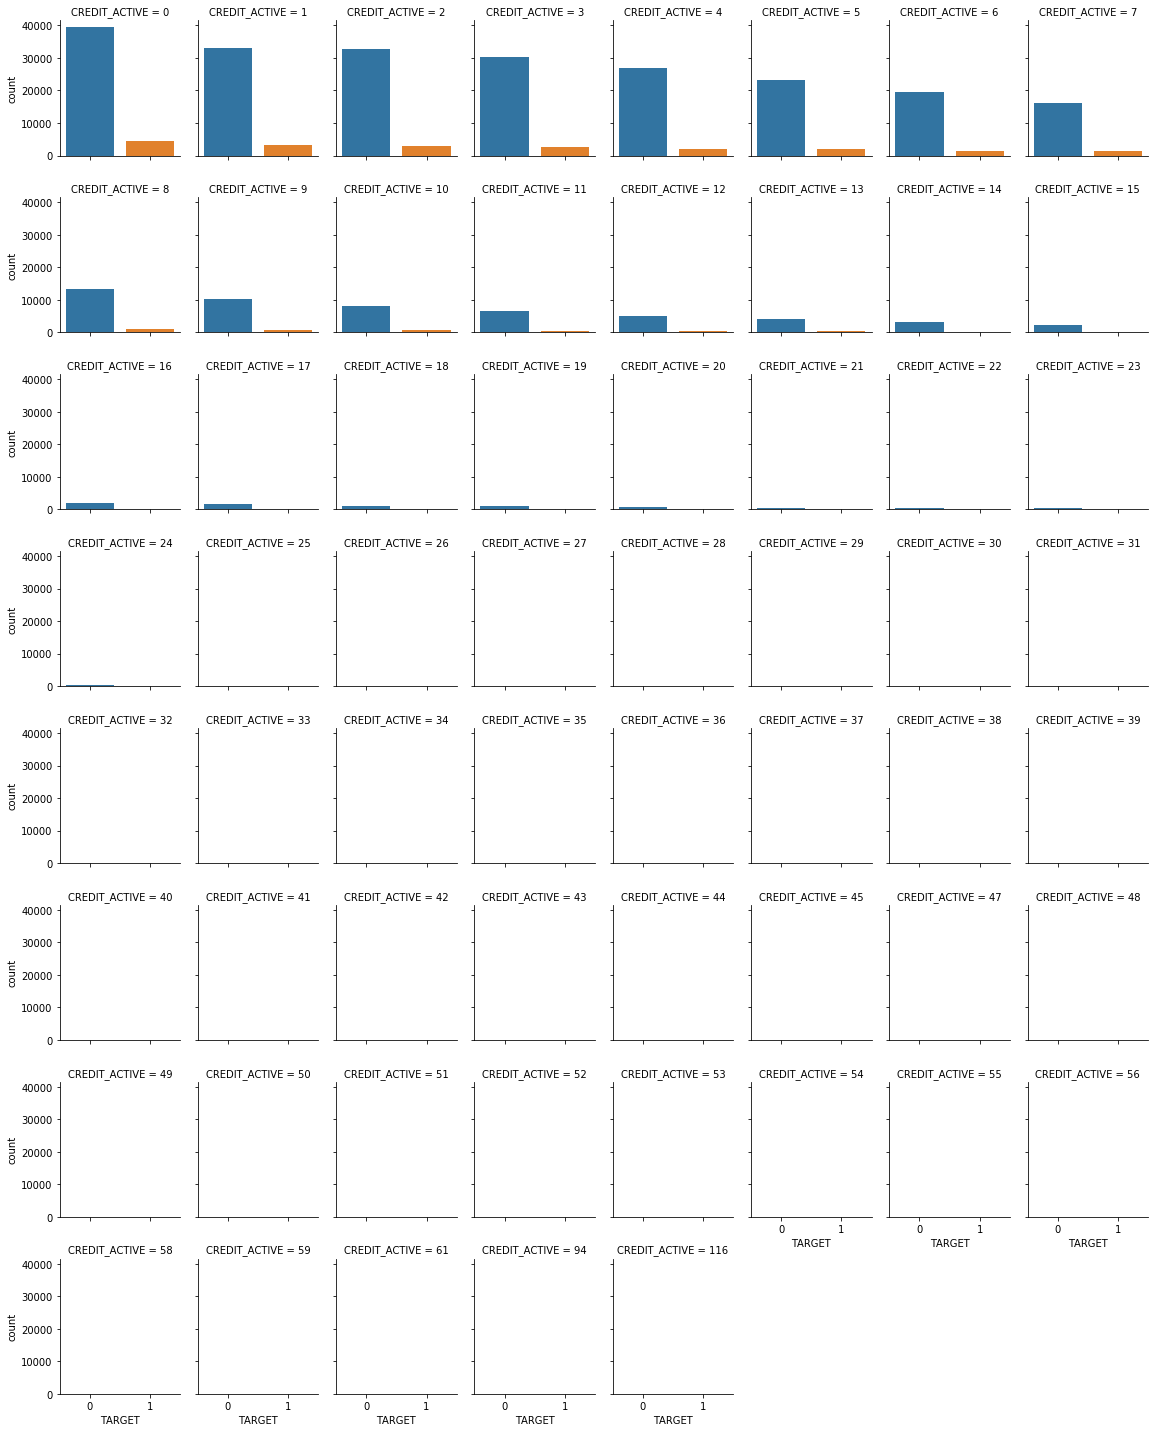

In [36]:
g = sns.catplot("TARGET", col="CREDIT_ACTIVE", col_wrap=8,
                data=bureau_credit_active,
                kind="count", height=2.5, aspect=.8)